# Practical task sheet 02 -- quality estimation, video encoding
The second task sheet will cover topics related to video encoding, here we will only work with low-resolution videos, to demonstrate the methods that can be further used for larger resolution videos.
This trade-off is required to run this task sheet in a given time.

To prepare for the tasks the following material should be checked out:

* https://en.wikipedia.org/wiki/Video_quality
* https://en.wikipedia.org/wiki/Subjective_video_quality
* https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio
* https://en.wikipedia.org/wiki/Structural_similarity
* https://en.wikipedia.org/wiki/Dynamic_Adaptive_Streaming_over_HTTP
* https://en.wikipedia.org/wiki/JPEG
* https://en.wikipedia.org/wiki/Motion_estimation


**General Hint**: in each code cell the parts where code needs to be added are marked with TBD, prefer simple code than complicated.
It is further not a problem if you cannot solve all tasks.

In [68]:
# version 2.0

In [69]:
# install requirements (this cell should not produce any errors, otherwise check dependencies and guide)
!pip install --user numpy pandas matplotlib scipy jupyter scikit-image scikit-learn scikit-video

In [70]:
# helper functions
import os
# add the local path of the "to be downloaded ffmpeg and ffprobe" to the search path
os.environ["PATH"] = "tools" + os.pathsep + os.environ["PATH"]

import shutil 
import platform
import urllib.request
import glob


# enables inline plots
%matplotlib inline  

import numpy as np

from scipy.fftpack import dct, idct


import skimage.io
import skimage.color
from skimage import img_as_uint

import pandas as pd
from IPython.display import display as d  # display nice tables in jupyter

def show_image(img):
    skimage.io.imshow(img)
    skimage.io.show()


def iterate_by_frame(video_filename):
    """ iterator over all frames a video given by `video_filename`,

    Parameters
    ----------
    video_filename : str
        filename of a video file

    Returns
    -------
    interator for all video frames
    """
    for frame in skvideo.io.vreader(video_filename, verbosity=0):
        yield img_as_uint(frame)

        
def iterate_by_frame_two_videos(distortedvideo, referencevideo):
    """
    interates over a pair of videos (distortedvideo, referencevideo) and returns pairs of frames (dis_frame, ref_frame),
    Important, if videos don't have the same number of frames it will stop after min(frames(dis), frames(ref)) frames.
    """
    dis_it = iterate_by_frame(distortedvideo)
    ref_it = iterate_by_frame(referencevideo)
    try:
        while True:
            x = next(dis_it)
            y = next(ref_it)
            yield (x, y)
    except Exception as e:
        print(e)


# ffmepg & ffprobe specific

def _get_file(url, target_filename_and_path):
    """
    downloads a file from `url` to `target_filename_and_path`
    """
    if os.path.isfile(target_filename_and_path):
        # prevent of downloading several times
        return True
    try:
        urllib.request.urlretrieve(url, target_filename_and_path)
    except urllib.error.URLError as e:
        return False
    return True

def download_local_ffmpeg_ffprobe():
    """ will download binaries for ffprobe and ffmpeg to tools directory """
    print("download local installed ffmpeg and ffprobe for your OS, download will take some time")
    os.makedirs("tools", exist_ok=True)

    ffprobe_links = {
        "win": {
            "link": "https://cloud.tu-ilmenau.de/s/S4ZR97kdpgCS7pD/download",
            "exe": os.path.join("tools", "ffprobe.exe")
        },
        "macos": {
            "link": "https://cloud.tu-ilmenau.de/s/XgT4NWjqNrtjkNK/download",
            "exe": os.path.join("tools", "ffprobe")
        },
        "linux": {
            "link": "https://cloud.tu-ilmenau.de/s/sT23KSsD3XRw9yb/download",
            "exe": os.path.join("tools", "ffprobe")
        }
    }
    ffmpeg_links = {
        "win": {
            "link": "https://cloud.tu-ilmenau.de/s/dnWb9nkp4t3TRx6/download",
            "exe": os.path.join("tools", "ffmpeg.exe")
        },
        "macos": {
            "link": "https://cloud.tu-ilmenau.de/s/QxYxgpqo8DtzQDk/download",
            "exe": os.path.join("tools", "ffmpeg")
        },
        "linux": {
            "link": "https://cloud.tu-ilmenau.de/s/f2nFkomjNQecScr/download",
            "exe": os.path.join("tools", "ffmpeg")
        }
    }

    ffprobe = shutil.which("ffprobe") # system version as fallback, not sure if this works for Windows
    ffmpeg = shutil.which("ffmpeg")

    make_executable = False
    os_name = "default"
    os_mapping = {
        "Windows": "win",
        "Darwin": "macos",
        "Linux": "linux"
    }
    if platform.system() in os_mapping:
        os_name = os_mapping[platform.system()]

    if os_name in ffprobe_links:
        tmp = _get_file(ffprobe_links[os_name]["link"], ffprobe_links[os_name]["exe"])
        ffprobe = ffprobe_links[os_name]["exe"]

    if os_name in ffmpeg_links:
        tmp = _get_file(ffmpeg_links[os_name]["link"], ffmpeg_links[os_name]["exe"])
        ffmpeg = ffmpeg_links[os_name]["exe"]

    if os_name in ["linux", "macos"]:
        os.system(f"chmod +x {ffprobe}")  # not sure if this works for MACOS, or is even required
        os.system(f"chmod +x {ffmpeg}")

    print(f"ffmpeg executable used {ffmpeg}")
    print(f"ffprobe executable used {ffprobe}")
    return ffmpeg, ffprobe

ffmpeg, ffprobe = download_local_ffmpeg_ffprobe()
# end of ffmepg & ffprobe specific


import skvideo.io


print(
    skvideo.getFFmpegPath()
)
assert(
    "tools" in skvideo.getFFmpegPath()
)

download local installed ffmpeg and ffprobe for your OS, download will take some time
ffmpeg executable used tools\ffmpeg.exe
ffprobe executable used tools\ffprobe.exe
C:\Users\Abdul Moanam\VST_Abdul_Moanam\VST\ts02_moanam_abdul\tools



## Subtask 1: quality estimation

Let's assume, we successfully recorded a video in high quality (uncompressed, or visually lossless compressed), we post-processed the video (removed noise, perform video cutting, added audio), and we want to prepare it in a way that it can be used for delivery.
Several possible distribution methods are thinkable, ranging from DVD, Bluray to HTTP-based streaming.
For all methods, compression is required, because an uncompressed video signal would not fit the transmission medium of our choice.
However there are plenty of possibilities to encode a given video, it is thus hard to know which one is best suitable.
For such reasons, quality estimation methods, that originate from image quality, can be used to check whether a codec, an encoding setting, ... fits the required quality for transmission.

Implement in the following task PSNR to estimate the video quality for the given encoded video `encoded.mkv` that is an encoded version of `ref.mkv`.
PSNR needs to be calculated using a reference signal, for this reason, you need to read the encoded and reference video. 
Moreover, it is required to perform PSNR calculation for each frame pair where for each $Y, C_b, C_r$ plane individual PSNR values are calculated.
The overall video quality is finally defined in this task sheet as 

$$Q(encoded, reference) =\frac{1}{4} \cdot (2 \cdot PSNR_Y(encoded, reference) + PSNR_{C_b}(encoded, reference) + PSNR_{C_r}(encoded, reference) )$$

with $PSNR_{X}(encoded, reference)$ refers to the mean $PSNR$ value of all video frames considering the $X$ color plane.
So in general our estimated quality score $Q$ is a weighted sum of all channel mean PSNR values for all video frames.

In these tasks we only consider 8it videos, similar approaches can be done for higher bit depths.

In [71]:
def psnr_image(encoded_plane, reference_plane):
    """
    calculate psnr for a given color plane pair, here both image planes are 8 bit
    """
    assert(len(encoded_plane.shape) == 2)
    assert(len(reference_plane.shape) == 2)
    
    mse =  np.mean ((encoded_plane - reference_plane )**2) # TBD
    if np.array_equal(encoded_plane, reference_plane):  #TBD check if both images are equal
        return np.inf  
    max_i = 255 # TBD
    psnr_img = 20 * np.log10(max_i/np.sqrt(mse))
    return psnr_img # TBD

# some checks for the methods
print(psnr_image(np.array([[1,2],[2,3]]), np.array([[1,2],[2,3]])))
print(psnr_image(np.array([[1,2],[2,3]]), np.array([[2,2],[2,3]])))


inf
54.15140352195873


In [72]:
def Q(encoded, reference):
    """ Q is a full reference quality measure, that is a weighted sum of PSNR mean values over 
        all color channels in Y,C_b,C_r space. 
    """
    # iterate over all video frame pairs, for simplicity we assume
    #  the reference.mkv and encoded.mkv have always the same number of frames
    psnr_y = []  # per frame psnr_y values are collected here
    psnr_c_b = []
    psnr_c_r = []
    frame_count = 0
    for (dis, ref) in iterate_by_frame_two_videos(encoded, reference):
        # convert each frame to Y,C_b,C_r using skimage.color.rgb2ycbcr
        dis_yuv = skimage.color.rgb2ycbcr(dis) # TBD
        ref_yuv = skimage.color.rgb2ycbcr(ref) # TBD
#         psnr vaues for each individal channel
        yp = psnr_image(dis_yuv[:,:,0], ref_yuv[:,:,0])
        cbp = psnr_image(dis_yuv[:,:,1], ref_yuv[:,:,1])
        crp = psnr_image(dis_yuv[:,:,2], ref_yuv[:,:,2])
        
        # collect the psnr image values for each channel in individual lists
        psnr_y.append(yp)  # TBD
        psnr_c_b.append(cbp)  # TBD
        psnr_c_r.append(crp)  # TBD
        frame_count += 1
    
    # calculate mean values of each channel
    mean_psnr_y =  np.mean(psnr_y)    # TBD
    mean_psnr_c_b = np.mean(psnr_c_b)   # TBD
    mean_psnr_c_r  = np.mean(psnr_c_r)  # TBD

    # return the final weighted sum of psnr values
    return (1 / 5)*(3*mean_psnr_y + mean_psnr_c_b + mean_psnr_c_r) # TBD


print(Q("encoded.mkv", "reference.mkv"))


38.89375048234716


## Subtask 1.1: crf encoding and quality
To figure out a good fitting encoding setting, it is thus required to encode a video with several settings.
So encode the "reference.mkv" video with the following settings $crf \in [23, 32, 42]$, use as video codec libx264 
and calculate for each setting the corresponding video quality $Q$ as defined in the task.


In [73]:
# encode the "reference.mkv" video to several variants using ffmpeg
# and calculate Q estimation for each resulting encoded video

def ffmpeg_crf_encode(video, crf_value, encoded_video):
    """ encodes a given `video` with a specified `crf_value` and stores the encoded video as `encoded_video` """
    if os.path.isfile(encoded_video):
        # we dont want to re-encode again and again if we run this cell several times
        return
    os.system(f"{ffmpeg} -i {video} -c:v libx264 -crf {crf_value} {encoded_video}")   #TBD   # this is a command , f"{ffmpeg}" will use the local installed ffmpeg

for crf in [23,32,42] :   # TBD
    ffmpeg_crf_encode("reference.mkv", crf, f"encoded_{crf}.mkv") 
    print(Q(f"encoded_{crf}.mkv", "reference.mkv"))


44.67481125287068

40.56470560143321

36.347649290824016


## Subtask 1.2: reverse engineer crf value 
We want to use the developed Q estimation to figure out which CRF encoding was used for the provided "encoded.mkv" video file.

We will use `encoded.mkv` as "reference video" in your quality calculation, the rationale behind this is, that the Q value should be a maximum in the case where both videos are "about equal", meaning we use the quality estimation as similarity measure.

We collect all quality values and later plot/estimate the used crf setting.

**Hint:** libx264 crf values range $\in[0,51]$

In [74]:
sim_values = []
for crf in range (0, 52):   # TBD
    ffmpeg_crf_encode("reference.mkv", crf, f"encoded_{crf}.mkv")   # TBD
    res = Q(f"encoded_{crf}.mkv", "reference.mkv")  # TBD
    sim_values.append({"crf": crf, "sim": res})


,crf,sim
0,0,inf
1,1,57.663908
2,2,56.505207
3,3,55.392033
4,4,54.305115
5,5,53.347768
6,6,52.438708
7,7,51.683231
8,8,51.026975
9,9,50.397417


the used crf value was 0


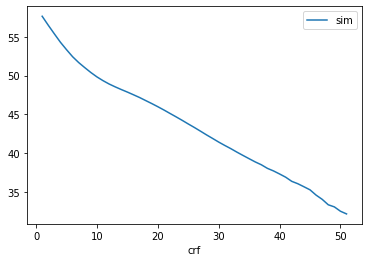

In [75]:
# we plot the collected crf-similarity pairs of the previous cell 

# create a dataframe that handles the collected sim_values
df = pd.DataFrame(sim_values)  # TBD

# display the dataframe 
d(df)

# plot the results, using a simple line chart, x axis = crf, y axis = sim
df.plot(x="crf", y="sim")  # TBD

# select the resulting crf value
used_crf = df[df.sim == df.sim.max()].crf.values[0] # TBD   crf value from dataframe

# print the estimated used crf value of the encoded.mkv
print(f"the used crf value was {used_crf}")

## Subtask 2: video encoding
Until now we assumed to have access to a well-developed and robust lossy video compression method.
However, in the following task, we will develop an "h.261" style video encoder.
From a general point of view, a lossy video encoder consists of two main steps:

* some frames are handled as full images and compressed using an image compression algorithm (I frames)
* other frames are predicted using the information preserved in the I frames, 
    usually, block-based motion compensation is used (P, B-frames, in the following only P frames are considered)


afterward, all frames are stored efficiently and compressed using arithmetic coding, Huffman encoding, or similar.
For this non-lossy compression part, we will use NumPy's zip functionality.

Thus we will mainly implement the I-frame and P-frame handling, which can be seen as fundamental building blocks of a hybrid video codec.

# Subtask 2.1: I-frame compression
Let's start with I frame compression.
Here we simplify the given problem by the following assumptions:

* we use $Y,C_b,C_r$ color space of the given video / image signal, no chroma sub-sampling is performed
* we implement a jpeg compression variant, assuming a fixed block size (in our example $(8,8)$), 
    advanced video codecs use variable block sizes with macro blocks and hierarchies 
* we only handle 8 bit images/videos
* we consider only a small resolution due to performance
* we use the same quantization matrix for all $Y,C_b, C_r$ channel planes

<img src="jpeg_style_comp.svg" alt="jpeg style compression" style="width:90%" >


We want to implement the following I frame compression algorithm for a given image $img$ with a quality level $quality\in[0,1]$:

* for each color plane in $Y,C_b,C_r$ space:
    * divide the given image into (8,8)-sized non overlapping blocks
    * for each block 
        * perform a DCT for the current block
        * quantize the DCT transformed image block $\leftarrow$ quantization matrix is given
        * round the quantized values and type cast them to integer
        * collect all transformed blocks 
    * collect transformed image plane 
* save the resulting compressed image using `np.savez_compressed(..)` as 'iframe.npz'


As before we will implement this step wise with some helper methods:

* `view_as_block` used to iterate over image with non overlapping blocks
* `dct_2d` 2D DCT
* `quantize_matrix` method to generate quantization matrices
* `encode_image_plane` compresses a single image plane
* `encode_image` encodes complete image
* `idct_2d` inverse 2D DCT
* `decode_image_plane` decodes image plane
* `decode_image` decodes image





In [76]:
def view_as_block(img, blocksize=(8,8)):
    """ this function returns views of the given image that have a defined blocksize
    important here, it uses the yield approach, that is similar to return, 
    however it has a state like an iterator in c++, thus we will get a series of 
    results if we call it again and again, a more detailed explanation can be found:
    https://stackoverflow.com/questions/231767/what-does-the-yield-keyword-do
    
    this method yields:
    
    i, j, imageblock
    
    where i and j are the corresponding coordinates of the block inside the image,
    thus top left corner of the block as coordinates
    """
    for i in range(0, img.shape[0], blocksize[0]):  # TBD
        for j in range(0, img.shape[1], blocksize[1]): # TBD
            block =img[i: i+blocksize[0],  j: j+blocksize[1]] # TBD
            yield i, j, block


# the view_as_block method will enable us to select non overlapping equi sized blocks of a given image.
dummy_image = np.array([
    [1,2,3,4],
    [5,6,7,8],
    [9,0,1,2],
    [3,4,5,6]
])
# this is just for verification of the view_as_block
for i, j, b in view_as_block(dummy_image, blocksize=(2,2)):
    print(i, j)
    print(b)
    print()
    
# the outut should be:
# 0 0
# [[1 2]
#  [5 6]]

# 0 2
# [[3 4]
#  [7 8]]

# 2 0
# [[9 0]
#  [3 4]]

# 2 2
# [[1 2]
#  [5 6]]

0 0
[[1 2]
 [5 6]]

0 2
[[3 4]
 [7 8]]

2 0
[[9 0]
 [3 4]]

2 2
[[1 2]
 [5 6]]



In [77]:
def dct_2d(block):
    """ perform a 2d DCT for the given block """
    # use dct from scipy.fftpack
    return dct(dct(block.T, norm = 'ortho').T, norm = 'ortho')  # TBD

# as next we need a 2D dct

# this is a check if your method returns what is expected
assert(dct_2d(np.array([[1,2],[2,3]]))[0,0].round(0) == 4)

In [78]:
# a base quantization matrix, based on the open jpeg standard, only the luminance matrix is used
Qb = np.array([
    [16,11,10,16,24,40,51,61],
    [12,12,14,19,26,58,60,55],
    [14,13,16,24,40,57,69,56],
    [14,17,22,29,51,87,80,62],
    [18,22,37,56,68,109,103,77],
    [24,35,55,64,81,104,113,92],
    [49,64,78,87,103,121,120,101],
    [72,92,95,98,112,100,103,99]
])

def quantize_matrix(quality):
    """ return for a specified quality level \in [0,1]  a quantization matrix
    """
    # based on https://stackoverflow.com/a/29216609
    Q = int(quality * 100) 
    S = 5000 / Q if (Q < 50) else 200 - 2 * Q
    Qm = Qb.copy()
    Qm = np.floor((S * Qm + 50) / 100)
    Qm[Qm == 0] = 1  # prevent divide by 0 error
    return Qm

# after applying DCT ususally the resulting values are quantized,
# for simplicity, we provide you a quality level adaptable quantization matrix
# so no todos here :)

In [79]:
def encode_image_plane(image, quality):
    """
    perform 2d dct to each image block with quantization
    """
    assert(len(image.shape) == 2)
    
    compressed_blocks = np.zeros(image.shape) # TBD inititalize compressed blocks with 0s
    Qm = quantize_matrix(quality)  
    for i, j, b  in view_as_block(image, (8,8)):  # iterate over all blocks
        block = b  # TBD
        # perform DCT, quantize and convert to np.int, save result in corresponding part of compressed_blocks
        dct = dct_2d(block)
        quantized = np.rint(dct/Qm)
        compressed_blocks[i:i+8, j:j+8] = quantized
    return compressed_blocks

# we will first handle to encode a single image plane/channel.
dummy_image = np.zeros([16,16])
dummy_image[8:11,8:12] = 10

# this is a check for the constructed dummy image plane
assert(encode_image_plane(dummy_image, 0.4).sum() == 4.0)


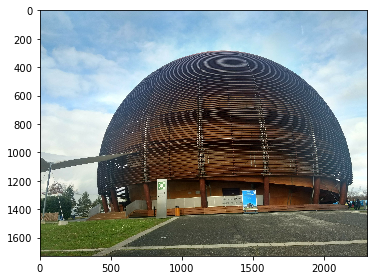

C:\Users\Abdul Moanam\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


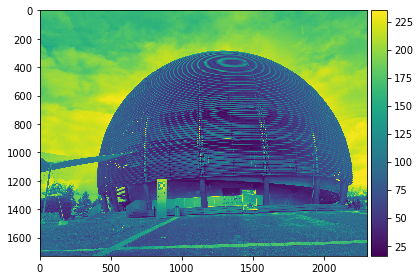

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


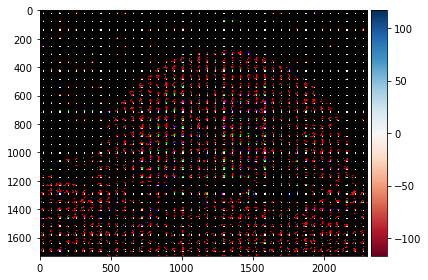

<ipython-input-80-f7f63c841c22>:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  compressed = compressed.astype(np.int)


In [80]:
def encode_image(img, compressed_filename=None, quality=0.5):
    # convert `img` to ycbcr using skimage.color.rgb2ycbcr
    ycbcr_image = skimage.color.rgb2ycbcr(img)   # TBD
        
    # show luminance channel
    show_image(ycbcr_image[:,:,0])
    compressed = np.zeros(ycbcr_image.shape)   
    # iterate over all color planes and compress each, store result in the corresponding plane of `compressed`
    for c in range (3):  # TBD iterate over channels
        e = encode_image_plane(ycbcr_image[:,:,c], quality)  # TDB compress channels
        # TBD store result in compressed image
        compressed[:,:,c] = e
    # show the final compressed image, yes it will not look great
    show_image(compressed)  
    
    # to ensure compatibility we perform a last typecast to np.int
    compressed = compressed.astype(np.int)
    
    if compressed_filename:
        # we use np.savez_compressed to store the result, if a filename is given, 
        # here a gzip based lossless compression will be performed automatically
        np.savez_compressed(compressed_filename, img=compressed, quality=quality)
    return compressed


# read "icomp.png" image 
iimage = skimage.img_as_ubyte(skimage.io.imread("icomp.png"))
show_image(iimage)

e = encode_image(iimage, "iframe.npz")

 as next we will handle the decoding part, this is more or less similar to encoding

In [81]:
def idct_2d(block):
    """ perform a 2d inverse DCT for a given block"""
    # use idct from scipy.fftpack 
    return idct(idct(block.T, norm = 'ortho').T, norm = 'ortho')  # TBD in a similar way than dct_2d

# we need a 2d inverse DCT
test_block = np.array([[1.0,2.0],[3.0,4.0]])
res = idct_2d(dct_2d(test_block))  # applying both dct and idct should end in an identity
assert((res.round(0) == test_block.round(0)).all())

In [82]:
def decode_image_plane(image, quality=1):
    """
    perform iversed 2d dct to each image block after dequantization, and decodes compressed image
    
    it is similar to encode image plane
    """
    assert(len(image.shape) == 2)
    decomp = np.zeros(image.shape)
    Qm = quantize_matrix(quality)
    for i, j, b  in view_as_block(image, (8,8)):
        # TBD: apply inverse dct to de quantized block and store result in decomp array
        dequantized = b * Qm
        i_dct = idct_2d(dequantized)
        decomp[i: i+8, j: j+8] = i_dct
    return decomp


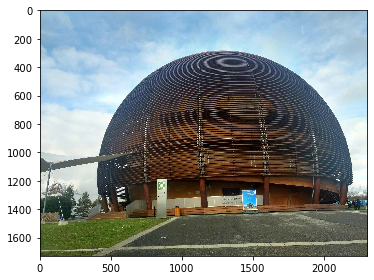

In [83]:
def decode_image(compressed_filename):
    """ decodes an image using the developed method
    """
    # load the image and quality level 
    file_content = np.load(compressed_filename)
    compressed = file_content["img"]
    quality = file_content["quality"]
    
    decompressed = np.zeros(compressed.shape) # TBD initialize with 0s
    for c in range (3):  # TDB iterate over color planes
        d = decode_image_plane(compressed[:,:,c], quality)  # TDB decode each color plane
        decompressed[:,:,c] = d #TDB and store decoded results in decompressed 
    return (np.clip(skimage.color.ycbcr2rgb(decompressed), 0, 1)* 255).astype(np.uint8)


dimage = decode_image("iframe.npz")
show_image(dimage)
skimage.io.imsave("dimage.png", dimage)

In [84]:
# print file-size of png image in kbytes, use an appropiate python method for the file-size
byte_size = os.path.getsize(r"C:\Users\Abdul Moanam\VST_Abdul_Moanam\VST\ts02_moanam_abdul\icomp.png")
k_bytes = byte_size / 1024
print("png", k_bytes) # TBD

# print file-size of compressed image (the numpy zipped export of your compression) in kbytes
byte_size = os.path.getsize(r"C:\Users\Abdul Moanam\VST_Abdul_Moanam\VST\ts02_moanam_abdul\iframe.npz")
k_bytes = byte_size / 1024
print("npz", k_bytes)  # TBD

png 3997.642578125
npz 885.0947265625


## Subtask 2.2: motion estimation
In the following cells, we will implement a simple motion estimation approach to make our developed video codec complete.
We will implement a simple variant of block-based motion estimation.
This allows us to reuse some of our previously implemented helper methods.

Check out the following:
* https://en.wikipedia.org/wiki/Block-matching_algorithm
* http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.736.5057&rep=rep1&type=pdf


<img src="block_matching.svg" alt="block matching" style="width:60%" >


In the following we assume:
* block matching is performed only on luminance channel, if two blocks are matching in luminance we take over their corresponding chrominance channels
* our block matching search is performed on the uncompressed video frames
* we only care about P frames, they only consider the previous frame in their motion estimation
* we implement exhaustive block matching search with max_distance and a blocksize of (8,8)
    * thus for a block at image position $i,j$, we check all blocks in the previouse frame in range $[i-max\_distance, i + max\_distance]$ and analog for $j$
    * important the range matches the image boundaries



In [85]:
def search_range(i, max_i, max_distance, blocksize):
    """ helper function to create an range iterator 
        for a specific coordinate i and max_i, maxdistance, and the blocksize,
        
        search_range ensures that only parts inside the 1D array boundaries are handled.
    """
    if (i+max_distance) < max_i:
        max_range = (i + max_distance) + 1 
    else:
        max_range = i # TBD
    
    if i < max_distance:
        min_range = 0 
    else:
        min_range = i - max_distance # TBD
        
    return range(min_range, max_range)


print(
    list(search_range(2, 10, 3, 2)),
    list(search_range(0, 10, 3, 2)),
    list(search_range(5, 10, 3, 2)),
    list(search_range(9, 10, 3, 2))
)

assert(list(search_range(2, 10, 3, 2)) == [0, 1, 2, 3, 4, 5])
assert(list(search_range(0, 10, 3, 2)) == [0, 1, 2, 3])
assert(list(search_range(5, 10, 3, 2)) == [2, 3, 4, 5, 6, 7, 8])
assert(list(search_range(9, 10, 3, 2))== [6, 7, 8])

[0, 1, 2, 3, 4, 5] [0, 1, 2, 3] [2, 3, 4, 5, 6, 7, 8] [6, 7, 8]


In [86]:
def exhaustive_search(prev, curr, blocksize=(8,8), max_distance=10):
    """
    performs an exhaustive block matching search with a blocksize of `blocksize`
    here a maximum distance of `max_distance` pixels is assumed, as error measure we use our implemented
    psnr_image, a block matches if it has either np.inf as psnr value or we take the block with max psnr out of
    all analyzed blocks
    
    """
    motion_vectors = np.zeros([curr.shape[0] // blocksize[0], curr.shape[1] // blocksize[1], 2]).astype(np.int)
    # our motion vector has image dimension // blocksize per coordinate and 2 channels as size
    # we only store coordinate shifts of corresponding blocks
    
    for i, j, b in view_as_block(curr, blocksize=blocksize):
        # TBD estimate block indices
        bi = i
        bj = j
        
        block_results = []
        equal_found = False
        # (ti, tj) refers to indices of the block under test
        for ti in search_range(i, curr.shape[0], max_distance, blocksize[0]):
            for tj in search_range(j, curr.shape[1], max_distance, blocksize[1]):
                # selct the block that we want to check
                block_to_check = prev[ti:ti+blocksize[0], tj:tj+blocksize[1]] # TBD
                # calculate psnr of block_to_check and block b 
                sim = psnr_image(block_to_check, b) # TBD
                block_results.append((ti, tj, sim))
                
                if sim == np.inf:  # here a full match is found
                    equal_found = True   # this breaks the loop to speedup if we already found a full match
                if equal_found:
                    break
            if equal_found:
                break
                
        ti, tj, sim = max(block_results,key=lambda item:item[2])  # TBD  # select the best matching block
        # store shifts of found block and analyzed block coordinates
        motion_vectors[bi,bj,0] = i # TBD 
        motion_vectors[bi,bj,1] = j # TBD
        
    return motion_vectors

prev_example = np.array([
    [1,2,3,4],
    [1,2,3,4],
    [1,2,3,4],
    [1,2,3,4]
])
curr_example = np.array([
    [0,1,2,3],
    [0,1,2,3],
    [0,1,2,3],
    [0,1,2,3]
])
print(exhaustive_search(prev_example, curr_example, blocksize=(2,2), max_distance=2))

<ipython-input-86-47a151cf5ffa>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  motion_vectors = np.zeros([curr.shape[0] // blocksize[0], curr.shape[1] // blocksize[1], 2]).astype(np.int)


IndexError: index 2 is out of bounds for axis 1 with size 2

In [ ]:
def predict_frame(prev, motion_vectors, blocksize=(8,8)):
    """
    usint the estimated motion vectors, this function predicts the next frame based on the previous
    
    here prev is a colored image and we just copy content based on the motion vectors
    """
    pred = np.zeros(prev.shape)  # create a zero copy
    for i in range(motion_vectors.shape[0]):
        for j in range(motion_vectors.shape[1]):
            # TBD
            x= -1
            y = -1
            # TBD end
    return pred.astype(np.uint8)

os.makedirs("pframe", exist_ok=True)

# iterate over a sequence of image frame pairs
frames = sorted(glob.glob("frames/*"))
i = 1
for prev, curr in zip(frames[0:-1], frames[1:]):
    prev = skimage.io.imread(prev)
    curr = skimage.io.imread(curr)
    
    # extract luminance channels
    prev_y = prev[:,:,0] # TBD
    curr_y = curr[:,:,0] # TBD
   
    # we create the motion vectors
    motion_vectors = prev_y - curr_y  # TBD
    
    # we recreate the motion predicted frame, and store the results
    predicted_frame = predict_frame(prev, motion_vectors)
    skimage.io.imsave(f"pframe/{str(i).zfill(3)}.png", predicted_frame)
    
    # visual check of the predicted frames
    show_image(predicted_frame - curr)

    i += 1

